In [1]:
import networkx as nx 
from matplotlib import pyplot as plt
import seaborn as sbn
import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx
import random
import torch
import copy
import pandas as pd
import gc
import torch_geometric as pyg 

from gsnn.models.GSNN import GSNN
from gsnn.models.NN import NN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate
from gsnn.optim.EarlyStopper import EarlyStopper
from gsnn.simulate.datasets import simulate_3_in_3_out

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn-mds/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


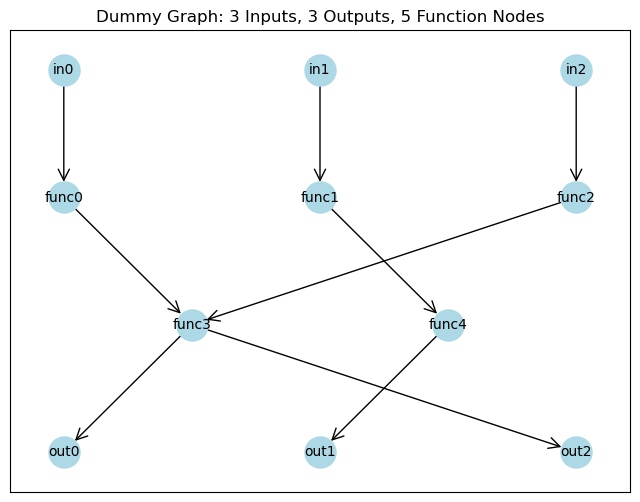

In [2]:
G, pos, x_train, x_test, y_train, y_test, input_nodes, function_nodes, output_nodes = simulate_3_in_3_out(n_train=10, n_test=100, noise_scale=0.1, device='cuda')

plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

# Performance comparison on simulated data

In [3]:
def train(model, model_params, train_params, x_train, y_train, x_test, y_test, device, max_epochs=500, patience=10): 

    gc.collect() 
    torch.cuda.empty_cache()

    model = model(**model_params).to(device)

    optim = torch.optim.Adam(model.parameters(), lr=train_params['lr'], weight_decay=train_params['weight_decay'])
    crit = torch.nn.MSELoss()

    early_stopper = EarlyStopper(patience=patience, min_delta=1e-3)

    losses = []
    for i in range(max_epochs): 
        model.train()
        optim.zero_grad() 
        yhat = model(x_train)
        loss = crit(y_train, yhat)
        loss.backward() 
        optim.step()

        with torch.no_grad(): 
            model.eval()
            loss = crit(model(x_test), y_test)
            losses.append(loss.item())
            if early_stopper.early_stop(loss): break

    del model; del optim; del crit 

    return losses

def run_search(model, model_params, training_params, x_train, y_train, x_test, y_test, device, iters=10):

    res = {**{k:[] for k in model_params.keys() if k not in ['edge_index_dict', 'node_names_dict']}, **{k:[] for k in training_params.keys()}}
    losses = []
    for i in range(iters): 
        print(f'progress: {i}/{iters}', end='\r')
        
        mp = {k:np.random.choice(model_params[k], size=1).item() for k,v in model_params.items()}
        tp = {k:np.random.choice(training_params[k], size=1).item() for k,v in training_params.items()}
        losses.append( train(model, mp, tp, x_train, y_train, x_test, y_test, device) )

        _=[res[k].append(v) for k,v in mp.items() if k not in ['edge_index_dict', 'node_names_dict']] 
        _=[res[k].append(v) for k,v in tp.items()]

    res = pd.DataFrame(res)
    return res, losses

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
iters = 200

gsnn_search_space = {'channels':np.arange(2, 40).tolist(), 
                'layers':[2,3,4],
                'share_layers':[True, False], 
                'add_function_self_edges':[True, False],
                'norm':['none', 'layer', 'batch', 'softmax', 'groupbatch'],
                'norm_first':[True, False],
                'init':['xavier_uniform', 'xavier_normal', 'kaiming_uniform', 'kaiming_normal', 'degree_normalized'],
                'bias':[True, False], 
                'node_attn':[True, False],
                'dropout':[0, 0.1],
                'residual':[True, False]}

gsnn_training_params = {'lr': [5e-1, 1e-2, 5e-3], 
                        'max_epochs':[100], 
                        'device':[device], 
                        'weight_decay':[0, 1e-2, 1e-4, 1e-6]} 

In [6]:
# GSNN with true graph structure
data = nx2pyg(G, input_nodes, function_nodes, output_nodes) 

model_params = {**{'edge_index_dict':[data.edge_index_dict], 
                'node_names_dict':[data.node_names_dict]}, 
                **gsnn_search_space}

res_gsnn, test_losses_gsnn = run_search(GSNN, model_params, gsnn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

res_gsnn = res_gsnn.assign(last_loss=[x[-1] for x in test_losses_gsnn], 
                            best_loss=[min(x) for x in test_losses_gsnn]) 


/home/teddy/local/GSNN/gsnn/models/GSNN.py:537: UserWarning: It is recommended to apply softmax normalization after the nonlinearity (set norm_first=False)
  if norm_first: warnings.warn('It is recommended to apply softmax normalization after the nonlinearity (set norm_first=False)')
/home/teddy/miniconda3/envs/gsnn-mds/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


In [7]:
# choose random edges from GSNN graph structure

edge_index_dict = copy.deepcopy(data.edge_index_dict)
E = edge_index_dict['function', 'to', 'function'].size(1)
edge_index_dict['function', 'to', 'function']  = torch.randint(low=0, high=len(function_nodes), size=(2,E))

model_params = {**{'edge_index_dict':[edge_index_dict], 
                'node_names_dict':[data.node_names_dict]}, 
                **gsnn_search_space}

res_gsnn_rand, test_losses_gsnn_rand = run_search(GSNN, model_params, gsnn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

res_gsnn_rand = res_gsnn_rand.assign(last_loss=[x[-1] for x in test_losses_gsnn_rand], 
                            best_loss=[min(x) for x in test_losses_gsnn_rand]) 



/home/teddy/local/GSNN/gsnn/models/GSNN.py:537: UserWarning: It is recommended to apply softmax normalization after the nonlinearity (set norm_first=False)
  if norm_first: warnings.warn('It is recommended to apply softmax normalization after the nonlinearity (set norm_first=False)')
/home/teddy/miniconda3/envs/gsnn-mds/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


In [8]:
# Fully connected GSNN (all nodes connected to each other)

edge_index_dict = copy.deepcopy(data.edge_index_dict)
edge_index_dict['function', 'to', 'function']  = torch.stack((torch.arange(len(function_nodes)).repeat_interleave(len(function_nodes)), 
                                                              torch.arange(len(function_nodes)).repeat(len(function_nodes))), dim=0)

model_params = {**{'edge_index_dict':[edge_index_dict], 
                'node_names_dict':[data.node_names_dict]}, 
                **gsnn_search_space}

res_gsnn_full, test_losses_gsnn_full = run_search(GSNN, model_params, gsnn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

res_gsnn_full = res_gsnn_full.assign(last_loss=[x[-1] for x in test_losses_gsnn_full], 
                            best_loss=[min(x) for x in test_losses_gsnn_full]) 


/home/teddy/local/GSNN/gsnn/models/GSNN.py:537: UserWarning: It is recommended to apply softmax normalization after the nonlinearity (set norm_first=False)
  if norm_first: warnings.warn('It is recommended to apply softmax normalization after the nonlinearity (set norm_first=False)')
/home/teddy/miniconda3/envs/gsnn-mds/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


In [9]:
nn_model_params = {'in_channels':[x_train.size(1)], 
                'out_channels':[y_train.size(1)], 
                'hidden_channels':[10,20,40,80,120], 
                'layers':[1,2,3],
                'norm':[torch.nn.BatchNorm1d, torch.nn.LayerNorm, None],
                'dropout':[0, 0.1, 0.25]}

nn_training_params = {'lr': [1e-2, 1e-3, 1e-4], 
                      'max_epochs':[100], 
                        'device':[device], 
                        'weight_decay':[0, 1e-2, 1e-4, 1e-6]} 

res_nn, losses_nn = run_search(NN, nn_model_params, nn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

In [10]:
print(f'best test loss NN: {min([min(loss) for loss in losses_nn])}')
print(f'best test loss GSNN: {min([min(loss) for loss in test_losses_gsnn])}')
print(f'best test loss GSNN (rand graph): {min([min(loss) for loss in test_losses_gsnn_rand])}')
print(f'best test loss GSNN (fully connected): {min([min(loss) for loss in test_losses_gsnn_full])}')

best test loss NN: 0.8405612707138062
best test loss GSNN: 0.5098376274108887
best test loss GSNN (rand graph): 0.9379295110702515
best test loss GSNN (fully connected): 0.5376312136650085


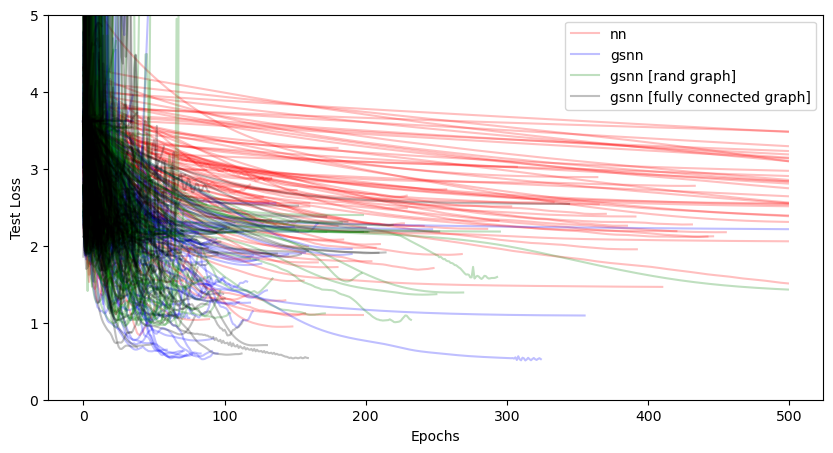

In [32]:
alpha = 0.25

plt.figure(figsize=(10,5))

for i, loss in enumerate(losses_nn): 
    if i == 0: 
        plt.plot(loss, 'r-', label='nn', alpha=alpha)
    else:
        plt.plot(loss, 'r-', alpha=alpha)

for i, loss in enumerate(test_losses_gsnn):
    if i == 0: 
        plt.plot(loss, 'b-', label='gsnn', alpha=alpha)
    else:
        plt.plot(loss, 'b-', alpha=alpha)

for i, loss in enumerate(test_losses_gsnn_rand):
    if i == 0: 
        plt.plot(loss, 'g-', label='gsnn [rand graph]', alpha=alpha)
    else:
        plt.plot(loss, 'g-', alpha=alpha)

for i, loss in enumerate(test_losses_gsnn_full):
    if i == 0: 
        plt.plot(loss, 'k-', label='gsnn [fully connected graph]', alpha=alpha)
    else:
        plt.plot(loss, 'k-', alpha=alpha)

plt.xlabel('Epochs')
plt.ylabel('Test Loss')

plt.ylim(0.,5)
plt.legend()
#plt.yscale('log')
plt.show()

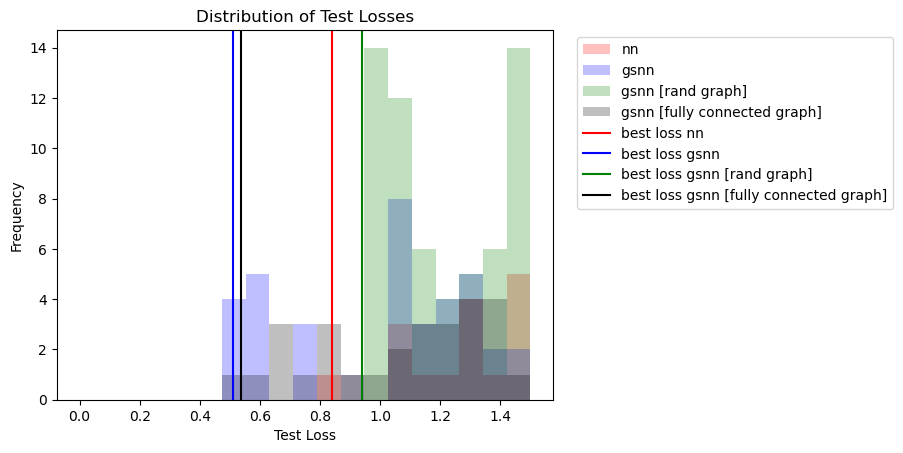

In [12]:
bins = np.linspace(0.,1.5,20)

plt.figure()
plt.hist([min(loss) for loss in losses_nn], label='nn', alpha=0.25, color='r', bins=bins)
plt.hist([min(loss) for loss in test_losses_gsnn], label='gsnn', alpha=0.25, color='b', bins=bins)
plt.hist([min(loss) for loss in test_losses_gsnn_rand], label='gsnn [rand graph]', alpha=0.25, color='g', bins=bins)
plt.hist([min(loss) for loss in test_losses_gsnn_full], label='gsnn [fully connected graph]', alpha=0.25, color='k', bins=bins)

plt.axvline(np.nanmin([min(loss) for loss in losses_nn]),  color='r', label='best loss nn')
plt.axvline(np.nanmin([min(loss) for loss in test_losses_gsnn]),  color='b', label='best loss gsnn')
plt.axvline(np.nanmin([min(loss) for loss in test_losses_gsnn_rand]),  color='g', label='best loss gsnn [rand graph]')
plt.axvline(np.nanmin([min(loss) for loss in test_losses_gsnn_full]), color='k', label='best loss gsnn [fully connected graph]')

plt.xlabel('Test Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Test Losses')

# place legend outside 
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))

plt.show()

In [13]:
# best gsnn hyper params 
res_gsnn.sort_values(by='best_loss', ascending=True).head(10)

,channels,layers,share_layers,add_function_self_edges,norm,norm_first,init,bias,node_attn,dropout,residual,lr,max_epochs,device,weight_decay,last_loss,best_loss
152,19,2,False,True,batch,False,degree_normalized,True,False,0.0,False,0.005,100,cuda,0.010000,0.526757,0.509838
156,23,3,False,True,groupbatch,False,kaiming_normal,True,False,0.1,True,0.010,100,cuda,0.010000,0.600811,0.525974
187,20,4,True,True,batch,False,kaiming_uniform,False,False,0.0,True,0.005,100,cuda,0.000001,0.588867,0.536564
118,35,4,True,True,batch,True,kaiming_normal,True,False,0.0,True,0.005,100,cuda,0.010000,0.582266,0.549145
191,8,3,False,True,batch,True,degree_normalized,False,False,0.0,True,0.005,100,cuda,0.000100,0.634280,0.559126
19,29,4,False,False,batch,True,xavier_uniform,False,False,0.1,True,0.005,100,cuda,0.000001,0.631997,0.561894
41,24,2,False,False,none,False,kaiming_uniform,True,True,0.1,True,0.005,100,cuda,0.000100,0.600415,0.569569
122,12,3,False,True,groupbatch,True,kaiming_normal,True,False,0.0,True,0.010,100,cuda,0.000001,0.636147,0.601235
130,17,3,False,True,groupbatch,True,kaiming_normal,True,False,0.1,False,0.010,100,cuda,0.000100,0.650356,0.628515
7,38,4,True,False,batch,True,xavier_uniform,False,False,0.1,True,0.005,100,cuda,0.010000,0.906103,0.720111


In [14]:
res_gsnn.sort_values(by='best_loss', ascending=False).head(10)

,channels,layers,share_layers,add_function_self_edges,norm,norm_first,init,bias,node_attn,dropout,residual,lr,max_epochs,device,weight_decay,last_loss,best_loss
14,23,4,True,True,none,True,kaiming_normal,False,False,0.0,True,0.500,100,cuda,0.000000,117000.242188,4005.760986
117,23,3,True,False,none,False,xavier_uniform,True,False,0.0,True,0.500,100,cuda,0.010000,223.683334,5.302968
29,21,3,False,False,groupbatch,False,kaiming_uniform,True,False,0.0,False,0.500,100,cuda,0.000100,26.631521,5.179683
67,21,4,False,True,none,True,kaiming_uniform,False,False,0.1,True,0.005,100,cuda,0.000000,4.596477,3.839054
54,16,3,False,True,none,False,kaiming_normal,False,False,0.1,False,0.010,100,cuda,0.000001,8.135767,3.643896
3,31,2,True,True,none,True,kaiming_normal,False,True,0.1,True,0.005,100,cuda,0.000001,4.018202,3.636117
27,20,3,True,True,none,True,degree_normalized,False,False,0.1,True,0.010,100,cuda,0.010000,3.922054,3.625559
60,18,2,False,False,none,True,degree_normalized,False,False,0.0,True,0.005,100,cuda,0.000100,3.640651,3.622704
102,6,3,True,True,none,False,degree_normalized,False,True,0.0,True,0.010,100,cuda,0.000100,3.638958,3.621718
71,21,3,False,True,layer,True,xavier_normal,False,True,0.1,True,0.500,100,cuda,0.000001,3.621515,3.621515


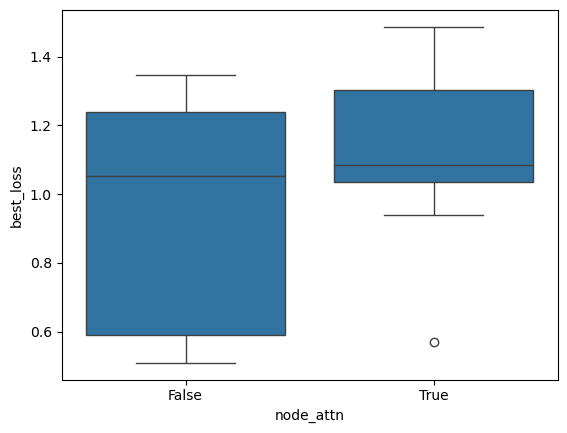

In [15]:
plt.figure()
sbn.boxplot(x='node_attn', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show()

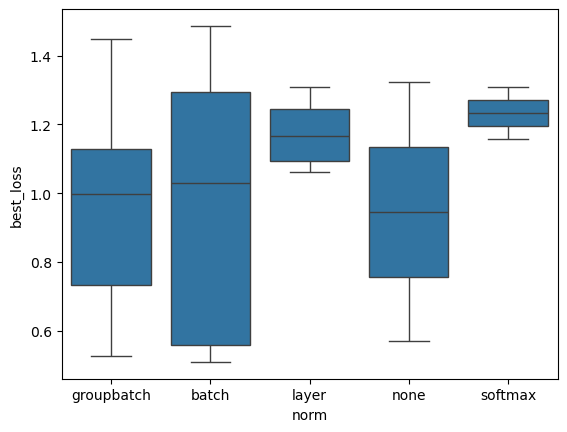

In [16]:
plt.figure()
sbn.boxplot(x='norm', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show()

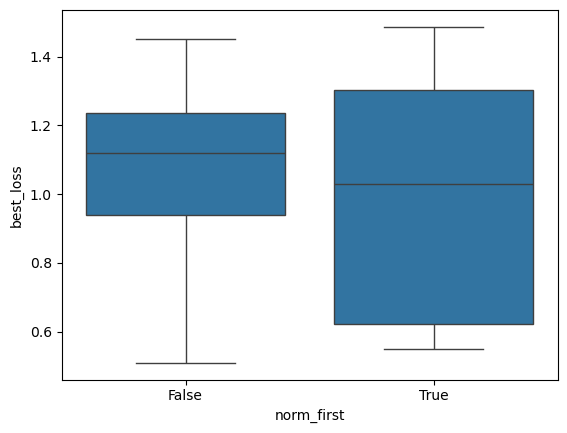

In [17]:
plt.figure()
sbn.boxplot(x='norm_first', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show()

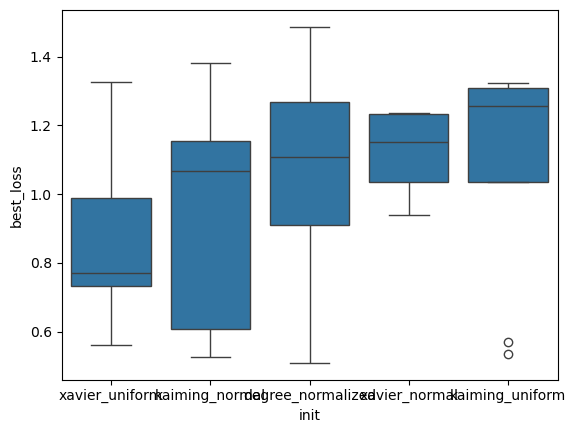

In [18]:
plt.figure() 
sbn.boxplot(x='init', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show()

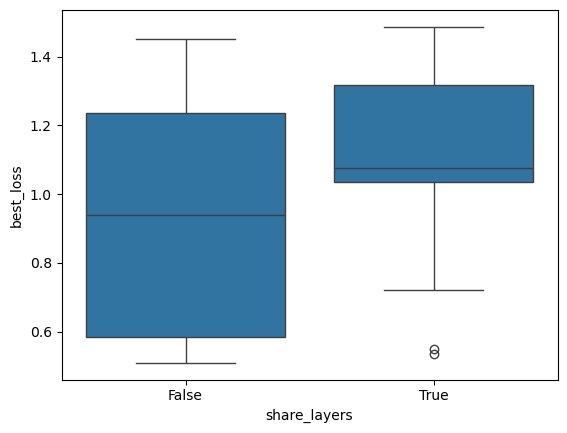

In [19]:
plt.figure() 
sbn.boxplot(x='share_layers', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

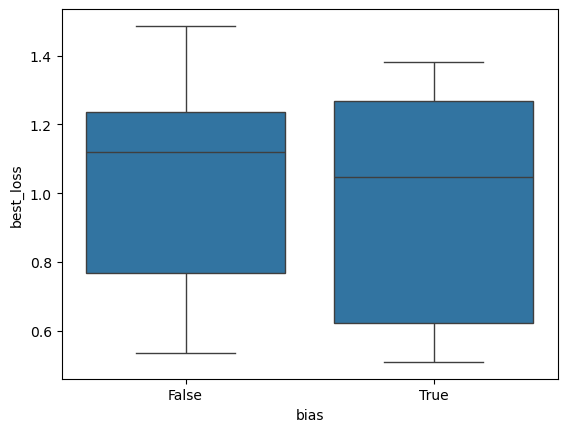

In [20]:
plt.figure() 
sbn.boxplot(x='bias', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

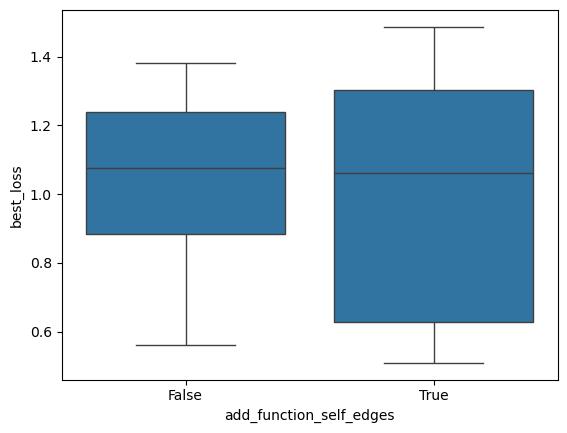

In [21]:
plt.figure() 
sbn.boxplot(x='add_function_self_edges', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

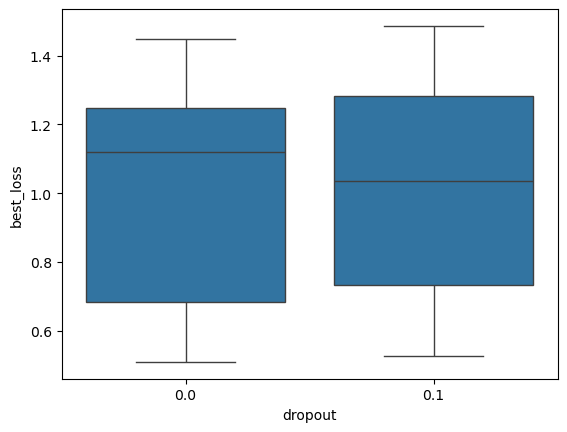

In [22]:
plt.figure() 
sbn.boxplot(x='dropout', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

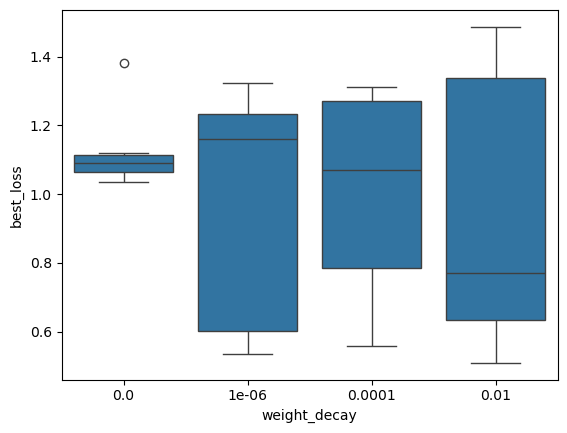

In [23]:
plt.figure() 
sbn.boxplot(x='weight_decay', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

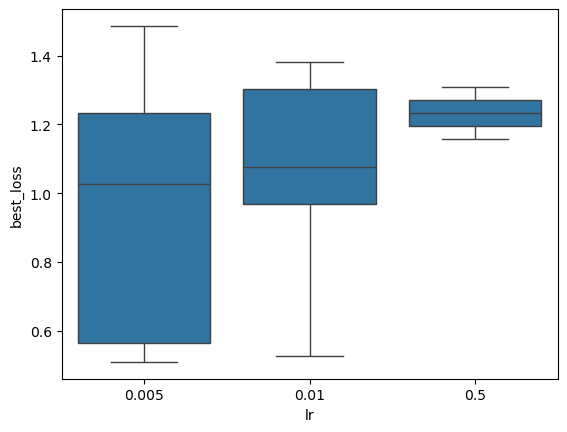

In [24]:
plt.figure() 
sbn.boxplot(x='lr', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

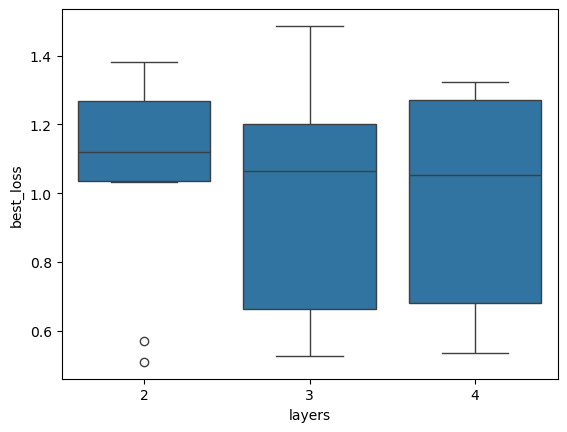

In [25]:
plt.figure() 
sbn.boxplot(x='layers', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

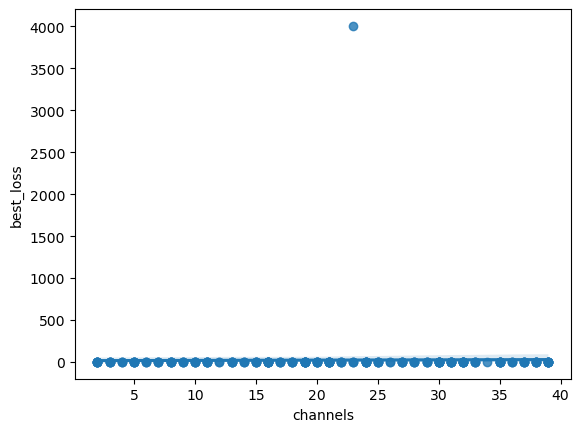

In [26]:
plt.figure() 
sbn.regplot(x='channels', y='best_loss', data=res_gsnn)
plt.show() 

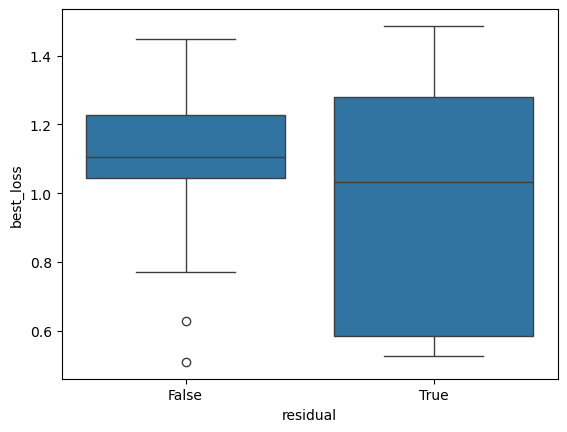

In [27]:
plt.figure() 
sbn.boxplot(x='residual', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 